In [1]:
import numpy as np
from scipy.optimize import curve_fit as cf
import scipy
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
from matplotlib import style
style.use('seaborn-talk')

In [2]:
data = 'Binary_data 2.csv'
t, z1, z2 = np.loadtxt(data, usecols=(0,1,2), unpack=True, delimiter=',')
c = 299792458 #SI 
G = 6.674e-11 #SI
t = t*31556952  #now in s, approximating a year to 365.2425  days

In [3]:
#Assuming stationary observer: v1,v2 are radial velocities of the stars wrt Earth
v1 = c*z1
v2 = c*z2

In [4]:
def fit_sin(tt, yy):
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0])) #almost uniform spacing
    fyy = abs(np.fft.fft(yy))
    
    guessed_amp = np.std(yy) * 2.**0.5
    guessed_freq = abs(ff[np.argmax(fyy[1:])+1])
    guessed_offset = np.mean(yy)
    
    guess = np.array([guessed_amp, 2.*np.pi*guessed_freq, 0., guessed_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = cf(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "angular freq": w, "phase": p, "offset": c, "fitter": fitfunc, "freq": f, "time period": 1./f, "max cov": np.max(pcov), "rawres": (guess,popt,pcov)}

In [5]:
ang_freq = fit_sin(t,v1)["angular freq"]
v_recession = fit_sin(t,v1)["offset"]

#Reuse frequency, phase and barycenter recession velocity- These are all common
def sin_func(t, A):  return A * np.sin(ang_freq*t + fit_sin(t,v1)["phase"]) + v_recession

curve_v1 = fit_sin(t,v1)["fitter"](t)

opt2, mat2 = cf(sin_func,t,v2)
curve_v2 = sin_func(t,*opt2)

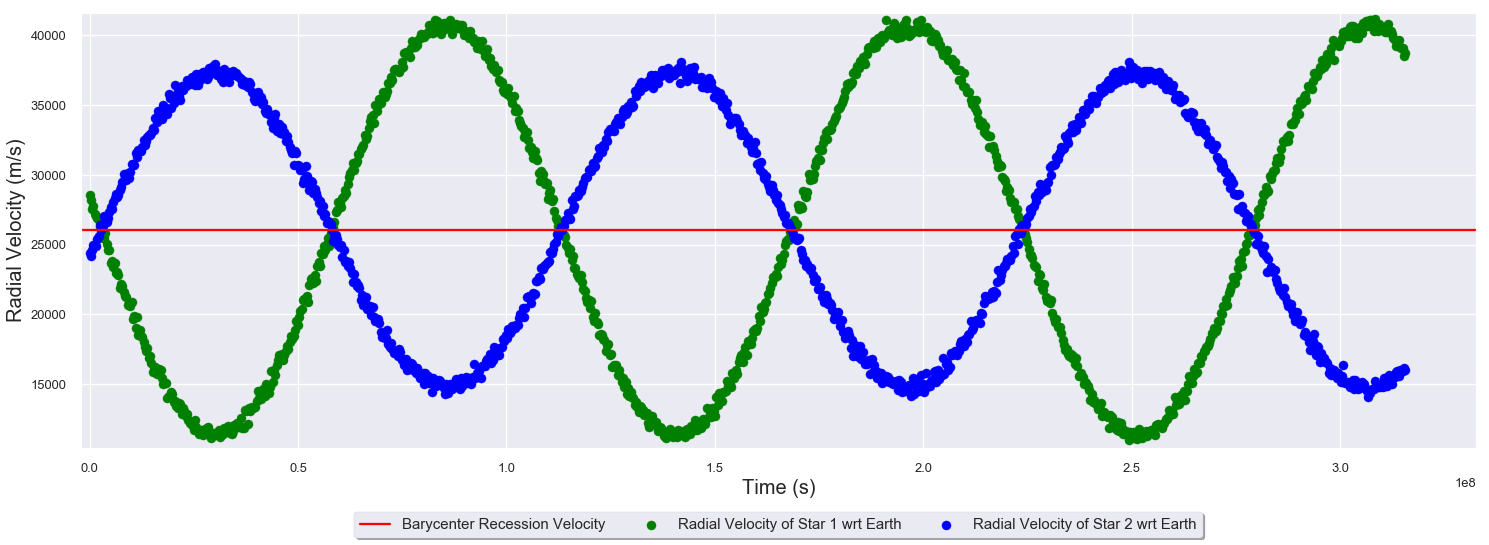

In [6]:
fig = plt.figure(figsize=(25, 8))
plt.scatter(t,v1,color='green',label='Radial Velocity of Star 1 wrt Earth')
plt.scatter(t,v2,color='blue',label='Radial Velocity of Star 2 wrt Earth')
plt.xlabel('Time (s)',fontsize=20)
plt.ylabel('Radial Velocity (m/s)',fontsize=20)

plt.ylim(0.95*v1.min(),1.01*v1.max())
plt.xlim(-0.02e8)
plt.axhline(y=v_recession,color='red',label='Barycenter Recession Velocity')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), shadow=True, ncol=3,fontsize = 15)
plt.show()

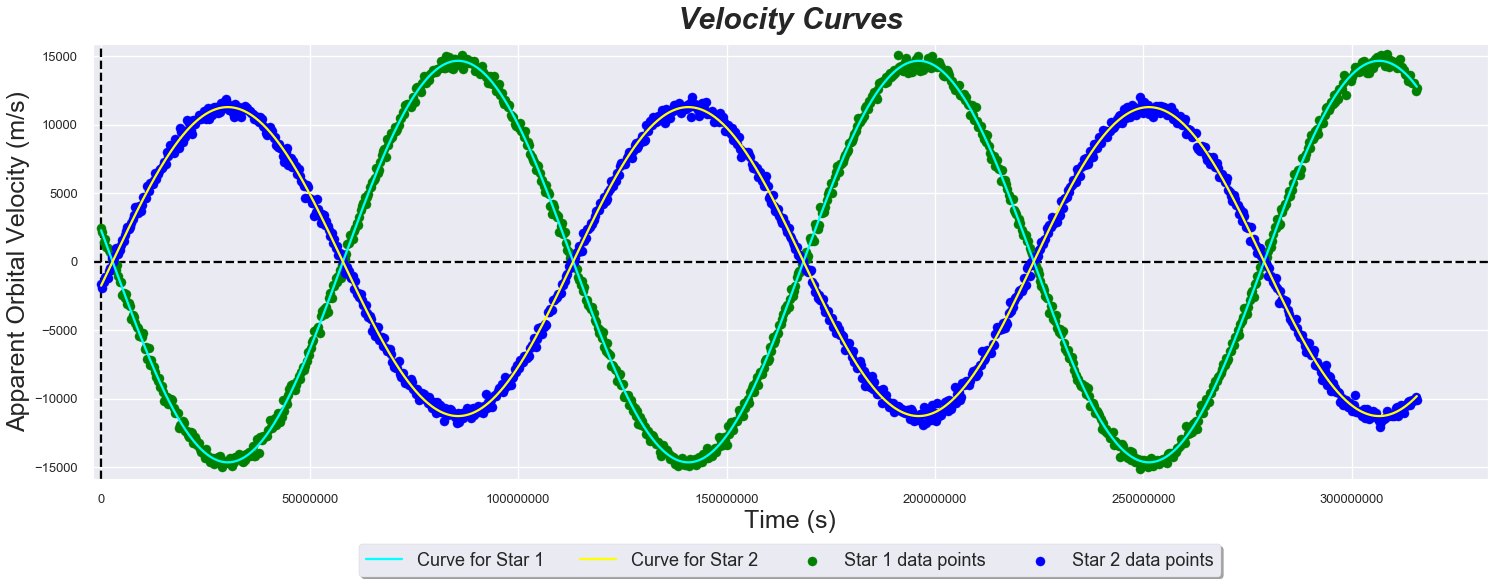

In [7]:
#Following are the apparent orbital velocities of the stars after taking barycenter velocity into account:
V1 = v1-v_recession
V2 = v2-v_recession

#Assumption: They are far enough for the barycenter radial velocity to be subtracted without worrying about its components

sin_v1 = curve_v1-v_recession
sin_v2 = curve_v2-v_recession

fig = plt.figure(figsize=(25, 8))
plt.axhline(y=0,linestyle='--',color='black',zorder=1)
plt.axvline(x=0,linestyle='--',color='black',zorder=2)

plt.scatter(t,V1,color='green',label='Star 1 data points',zorder=3)
plt.scatter(t,V2,color='blue',label='Star 2 data points',zorder=4)
plt.xlabel('Time (s)',fontsize=25)
plt.ylabel('Apparent Orbital Velocity (m/s)',fontsize=25)

plt.plot(t,sin_v1,color='aqua',label='Curve for Star 1',zorder=5)
plt.plot(t,sin_v2,color='yellow',label='Curve for Star 2',zorder=6)

plt.ylim(1.05*V1.min(),1.05*V1.max())
plt.xlim(-0.02e8)

plt.ticklabel_format(style='plain') #preventing scientific notation, just preference

plt.title('Velocity Curves',size=30,pad=15,fontweight='bold',fontstyle='italic')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), shadow=True, ncol=4,fontsize = 18)

#plt.savefig('Velocity Curves.png',dpi=750,facecolor='white',edgecolor='black')
plt.show()

In [8]:
#Following are the TRUE orbital velocities (speed) of the stars in a cicular orbit around their barycenter-
vo1 = np.max(sin_v1)
vo2 = np.max(sin_v2)

#print(f'Star 1 orbits the barycenter with a speed of about {vo1} m/s.')
#print(f'Star 2 orbits the barycenter with a speed of about {vo2} m/s.')

T = fit_sin(t,v1)["time period"]
#This is all the data required to calculate their mass-
M1 = T*vo2*(vo1+vo2)**2/(2*np.pi*G)
M2 = T*vo1*(vo1+vo2)**2/(2*np.pi*G)

In [9]:
print(f'Period of Revolution is: {T} seconds (or {T/31556952} years)')
print(f'Mass of lighter star is: {min(M1,M2)} kg')
print(f'Mass of heavier star is: {max(M1,M2)} kg')

Period of Revolution is: 110466412.13302816 seconds (or 3.500541247869191 years)
Mass of lighter star is: 1.9942438418049638e+30 kg
Mass of heavier star is: 2.5918596431222026e+30 kg
